In [2]:
!pip install association_metrics

In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import association_metrics as am

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression


from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# EDA

In [4]:
loans = pd.read_csv("Loan_default.csv")
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [7]:
loans = pd.read_csv("Loan_default.csv", 
                    dtype={'Education':'object','EmploymentType':'object',
                           'MaritalStatus':'object','HasMortgage':'object',
                           'HasDependents':'object','LoanPurpose':'object',
                           'HasCoSigner':'object'})
loans.dropna(inplace=True)
loans.drop_duplicates(inplace=True)
loans.sample(5)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
157160,7IGHRTOX48,49,29634,242123,428,31,3,24.72,36,0.48,Bachelor's,Full-time,Divorced,No,No,Other,No,1
222432,JFIBWN5Z8T,57,51689,94497,769,112,1,6.98,48,0.79,PhD,Unemployed,Divorced,Yes,Yes,Auto,No,0
199982,W1J89VCBF8,25,89418,129499,316,105,2,9.14,12,0.57,High School,Self-employed,Married,Yes,Yes,Business,No,0
100423,L9RQOY5CPH,25,86211,184392,847,112,3,18.40,24,0.64,Bachelor's,Unemployed,Married,Yes,No,Home,Yes,0
249114,0YCW4W92S3,26,89935,199985,819,16,4,5.92,24,0.77,High School,Part-time,Single,Yes,No,Home,Yes,1


In [8]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [9]:
# Describe Dataset
loans.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


In [ ]:
columns = loans.columns
fig, axs = plt.subplots(5, 2, figsize=(10, 10))
sns.boxplot(loans.iloc[:,1],ax=axs[0, 0],orient='h').set_title(columns[1])
sns.boxplot(loans.iloc[:,2],ax=axs[0, 1],orient='h').set_title(columns[2])
sns.boxplot(loans.iloc[:,3],ax=axs[1, 0],orient='h').set_title(columns[3])
sns.boxplot(loans.iloc[:,4],ax=axs[1, 1],orient='h').set_title(columns[4])
sns.boxplot(loans.iloc[:,5],ax=axs[2, 0],orient='h').set_title(columns[5])
sns.boxplot(loans.iloc[:,6],ax=axs[2, 1],orient='h').set_title(columns[6])
sns.boxplot(loans.iloc[:,7],ax=axs[3, 0],orient='h').set_title(columns[7])
sns.boxplot(loans.iloc[:,8],ax=axs[3, 1],orient='h').set_title(columns[8])
sns.boxplot(loans.iloc[:,9],ax=axs[4, 0],orient='h').set_title(columns[9])
fig.tight_layout()

In [10]:
loans.columns

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner',
       'Default'],
      dtype='object')

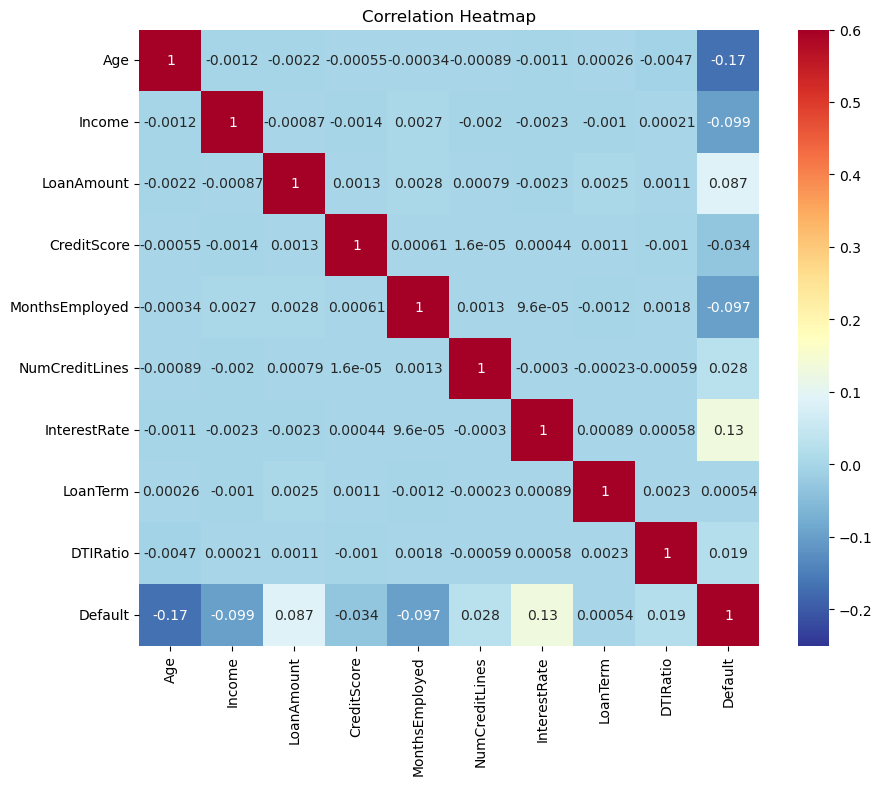

In [11]:
# Correlation Heatmap (Numerical Columns)
plt.figure(figsize=(10,8))
corr = loans.drop(columns=['LoanID','Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']).corr()
sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plots the distribution of a variable colored by value of the target
def kde_default(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['Default'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['Default'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['Default'] == 1, var_name].median()
    
    plt.figure(figsize=(12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['Default'] == 0, var_name], label='Default == 0')
    sns.kdeplot(df.loc[df['Default'] == 1, var_name], label='Default == 1')
    
    # Label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()
    
    # Print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid = %0.4f' % avg_repaid)

The correlation between Age and the TARGET is -0.1678
Median value for loan that was not repaid = 34.0000
Median value for loan that was repaid = 45.0000


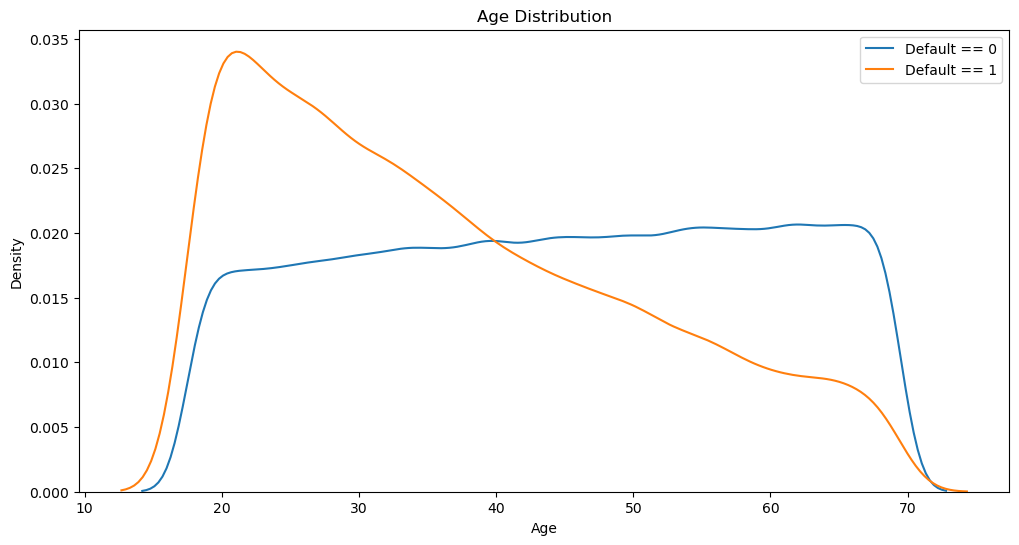

In [13]:
kde_default('Age', loans)

The correlation between InterestRate and the TARGET is 0.1313
Median value for loan that was not repaid = 16.9300
Median value for loan that was repaid = 12.9900


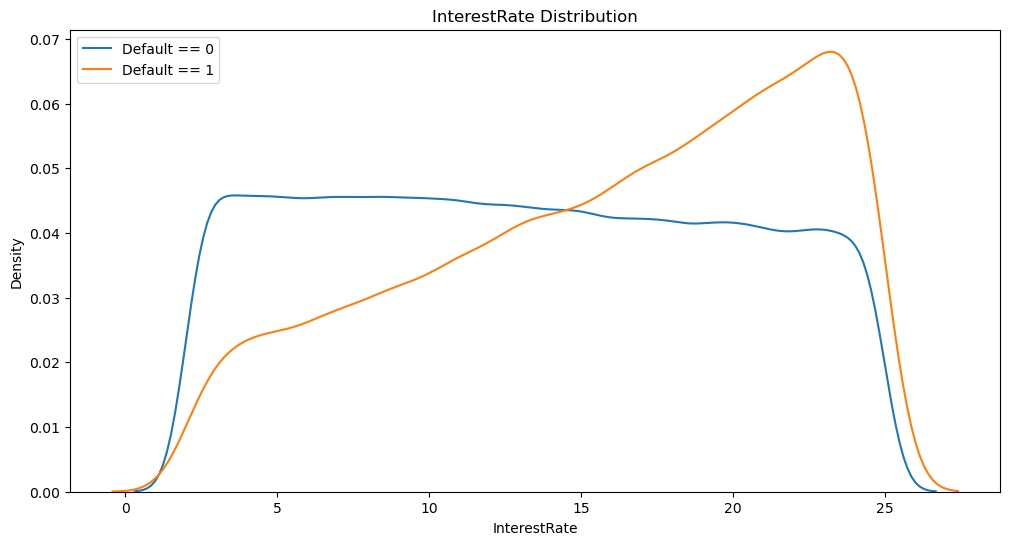

In [19]:
kde_default('InterestRate', loans)

The correlation between Income and the TARGET is -0.0991
Median value for loan that was not repaid = 66566.0000
Median value for loan that was repaid = 84237.5000


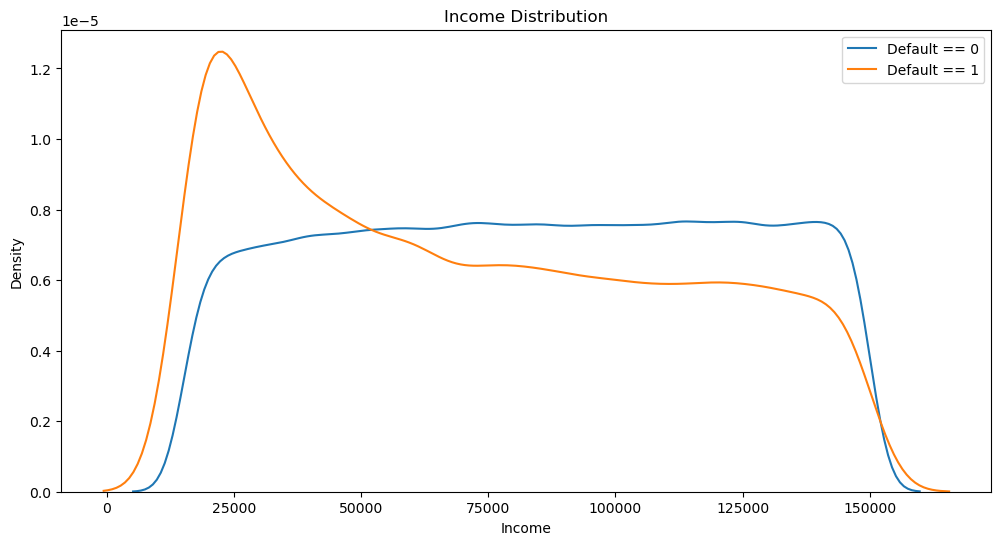

In [20]:
kde_default('Income', loans)

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in loans:
    if loans[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(loans[col].unique())) <= 2:
            # Train on the training data
            le.fit(loans[col])
            # Transform both training and testing data
            loans[col] = le.transform(loans[col])
#             app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [22]:
loans_init = loans.copy()
loans = loans.drop(columns = ['LoanID'])
loans = pd.get_dummies(loans)
print(loans.shape)
loans.columns

(255347, 29)


Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'HasMortgage',
       'HasDependents', 'HasCoSigner', 'Default', 'Education_Bachelor's',
       'Education_High School', 'Education_Master's', 'Education_PhD',
       'EmploymentType_Full-time', 'EmploymentType_Part-time',
       'EmploymentType_Self-employed', 'EmploymentType_Unemployed',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'LoanPurpose_Auto', 'LoanPurpose_Business',
       'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other'],
      dtype='object')

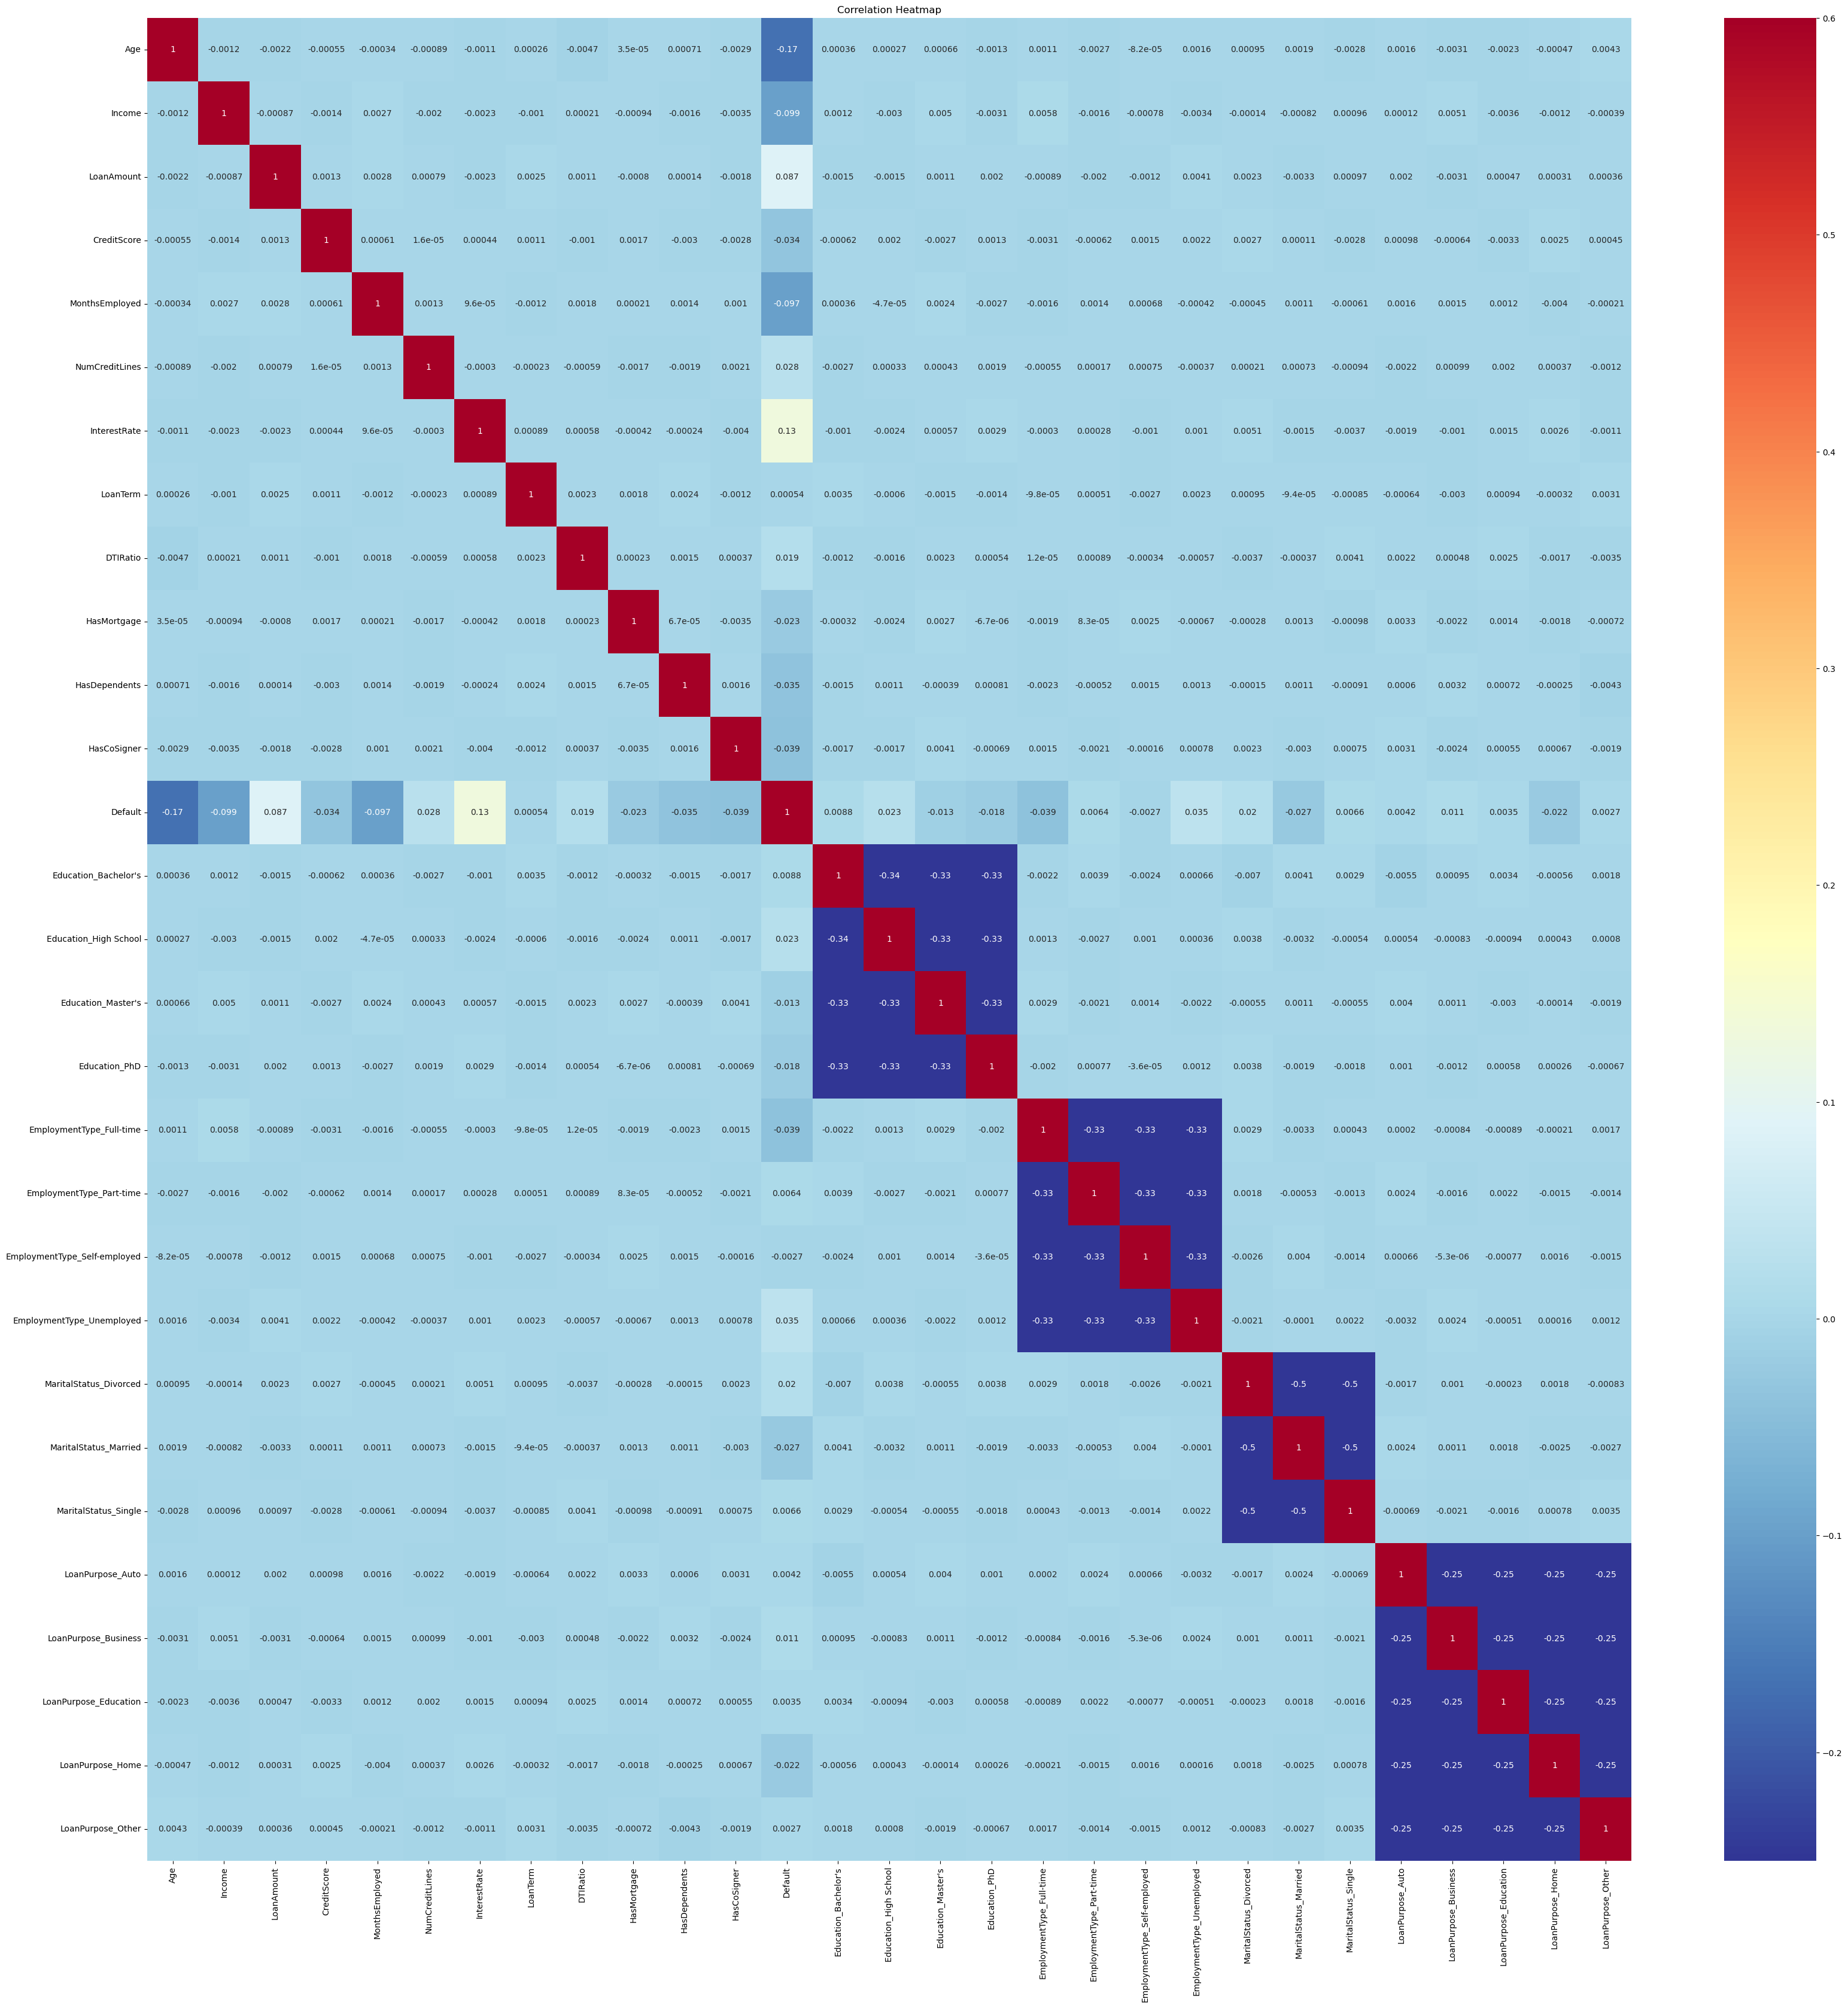

In [23]:
plt.figure(figsize=(40,40))
corr = loans.corr()
sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

# Feature Engineering 

In [24]:
loans['LoanToIncomeRatio'] = loans['LoanAmount']/loans['Income']
loans['FinancialRiskScore'] = loans['CreditScore'] - loans['LoanToIncomeRatio'] + (loans['MonthsEmployed']/12)

The correlation between LoanToIncomeRatio and the TARGET is 0.1790
Median value for loan that was not repaid = 2.0499
Median value for loan that was repaid = 1.4956


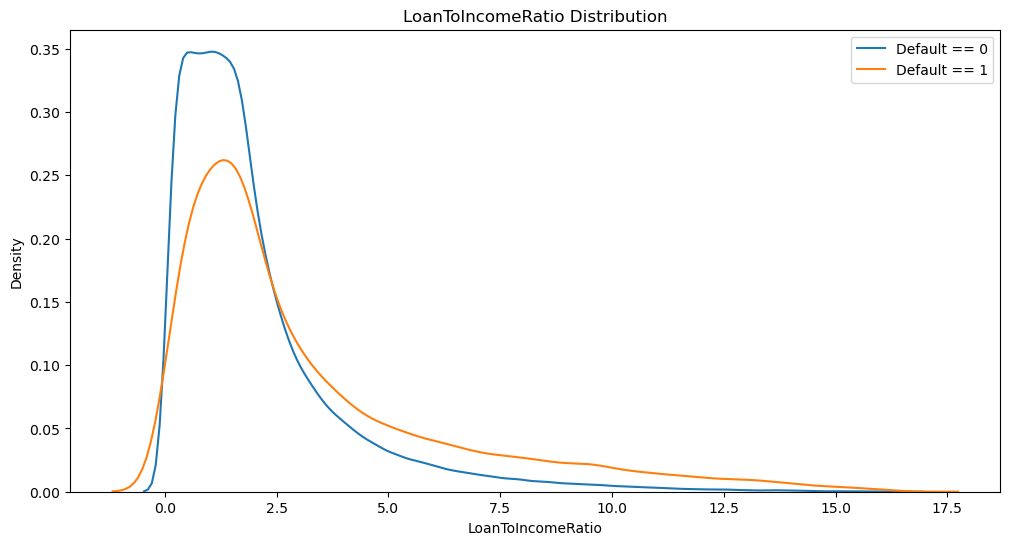

In [25]:
kde_default('LoanToIncomeRatio',loans)

The correlation between FinancialRiskScore and the TARGET is -0.0384
Median value for loan that was not repaid = 553.8528
Median value for loan that was repaid = 579.5443


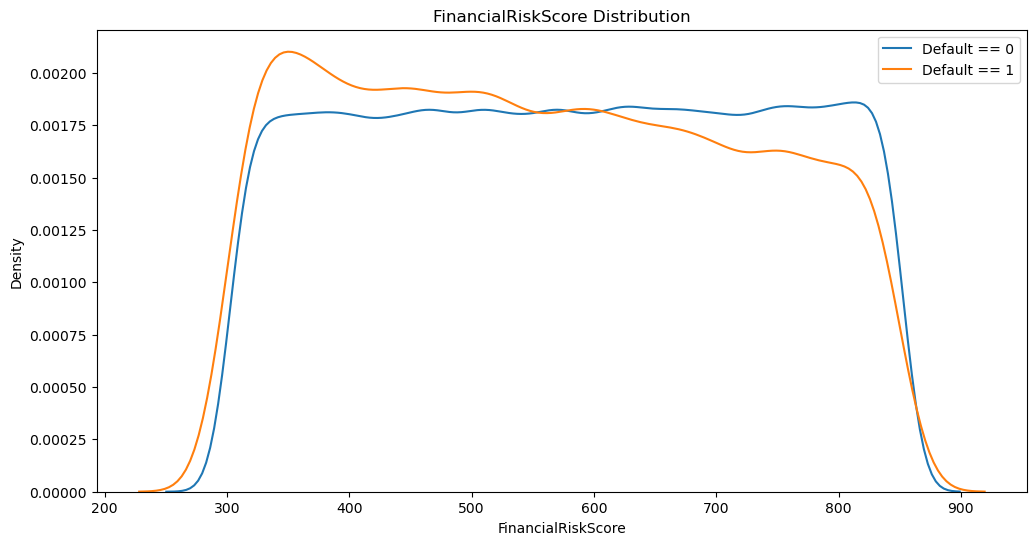

In [26]:
kde_default('FinancialRiskScore',loans)

In [27]:
# Split Dataset into train and test dataset
x_train,x_test,y_train,y_test = train_test_split(loans.drop(columns=['Default']),loans['Default'],
                                                 test_size=0.2,random_state=42)

print('x_train:',x_train.shape)
print('y_train:',y_train.shape)
print('x_test:',x_test.shape)
print('y_test:',y_test.shape)

x_train: (204277, 30)
y_train: (204277,)
x_test: (51070, 30)
y_test: (51070,)


In [28]:
import lightgbm as lgb
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(x_train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [29]:
for i in range(2):
    
    # Split into training and validation set
    #train_features, valid_features, train_y, valid_y = train_test_split(ft_train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(x_train, y_train, eval_set = [(x_test, y_test)], 
              eval_metric = 'auc')
    
    # Record the feature importances
    feature_importances += model.feature_importances_

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 23753, number of negative: 180524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=gos

In [30]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(x_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances

,feature,importance
6,InterestRate,34423.0
4,MonthsEmployed,29879.0
1,Income,29792.0
2,LoanAmount,29193.0
8,DTIRatio,27491.0
28,LoanToIncomeRatio,25465.0
0,Age,24871.0
3,CreditScore,23242.0
29,FinancialRiskScore,17380.0
7,LoanTerm,8587.0


In [31]:
transformer2 = ColumnTransformer([
    ('t2',MinMaxScaler(),slice(0,30))
])

In [32]:
# Creating a Pipeline
pipe = Pipeline([
    ('t2',transformer2)
])

temp_x_train = pd.DataFrame(pipe.fit_transform(x_train))
temp_x_test = pd.DataFrame(pipe.transform(x_test))

In [33]:
temp_x_train.shape

(204277, 30)

# Feature Extraction

In [34]:
pca = PCA(n_components=None)
temp_x_train = pca.fit_transform(temp_x_train)
temp_x_test = pca.transform(temp_x_test)

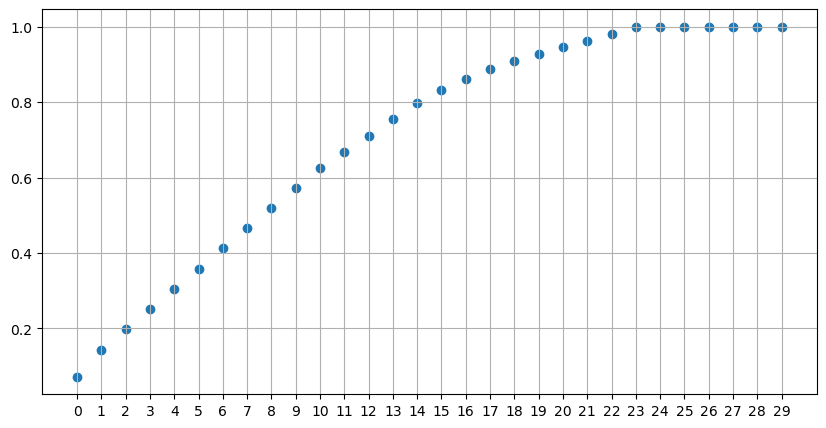

In [35]:
plt.figure(figsize=(10,5))
plt.scatter(range(0,30),np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(0,30))
plt.grid()
plt.show()

#### 23 parameters will cover almost 100% information about the dataset. So, using all 30 columns will waste time during training.

In [36]:
x_train = pd.DataFrame(pipe.fit_transform(x_train))
x_test = pd.DataFrame(pipe.transform(x_test))

pca = PCA(n_components=23)
x_train = pca.fit_transform(temp_x_train)
x_test = pca.transform(temp_x_test)

In [37]:
# Scaling Complete Dataset
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Model Training

In [38]:
from sklearn.model_selection import RandomizedSearchCV
import time
import numpy as np
import pandas as pd

# Define the models and their corresponding hyperparameters
models_and_params = {
    MultinomialNB(): {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    SGDClassifier(): {'loss':['log_loss','modified_huber','squared_hinge'],
                      'penalty':['l1','l2'],
                      'max_iter':np.arange(5000,10000,1000)},
    LinearSVC(): {'penalty':['l1','l2'],
                  'loss':['hinge','squared_hinge'],
                  'C':[1,5,10],
                  'max_iter':np.arange(1000,5000,1000)},
    LogisticRegression(): {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
}

# Define a function to perform grid search
def perform_grid_search(model, params):
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    return {'Best Parameters': grid_search.best_params_, 'Best Score': grid_search.best_score_}

# Use dictionary comprehension to create a new dictionary with the best parameters for each model
start_time = time.time()
best_params_and_scores = {model: perform_grid_search(model, params) for model, params in models_and_params.items()}
elapsed_time = np.round(time.time() - start_time, 2)


# Convert the dictionary to a DataFrame
best_params_and_scores_df = pd.DataFrame(best_params_and_scores).T.reset_index().rename(columns={'index': 'Model'})

print("\nTime taken for all models is", elapsed_time, "seconds")
print("\nBest Parameters and Scores:\n", best_params_and_scores_df)



Time taken for all models is 69.4 seconds

Best Parameters and Scores:
                   Model                                    Best Parameters  \
0       MultinomialNB()                                   {'alpha': 1e-05}   
1       SGDClassifier()  {'penalty': 'l2', 'max_iter': 6000, 'loss': 'l...   
2           LinearSVC()  {'penalty': 'l2', 'max_iter': 4000, 'loss': 'h...   
3  LogisticRegression()                                          {'C': 10}   

  Best Score  
0   0.883722  
1   0.885141  
2   0.883722  
3   0.885176  


In [39]:
from sklearn.model_selection import cross_val_score
import time
import pandas as pd

# Define the models
models = {
    'XGBClassifier': XGBClassifier(),
    'LGBMClassifier': LGBMClassifier()
}

# Define a function to get cross validation score
def get_cross_val_score(model):
    score = cross_val_score(model, x_train, y_train, cv=5, n_jobs=-1, verbose=5).mean()
    return score

# Use dictionary comprehension to apply cross_val_score to each model
start_time = time.time()
model_scores = {model_name: get_cross_val_score(model) for model_name, model in models.items()}
elapsed_time = np.round(time.time() - start_time, 2)


# Convert the dictionary to a DataFrame
model_scores_df = pd.DataFrame(model_scores.items(), columns=['Model', 'Score']).sort_values(by='Score', ascending=False).reset_index(drop=True)

print("\nTime taken for all models is", elapsed_time, "seconds")
print("\nScores:\n", model_scores_df)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.8s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished



Time taken for all models is 15.31 seconds

Scores:
             Model     Score
0  LGBMClassifier  0.885895
1   XGBClassifier  0.883908


In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

# MultinomialNB = MultinomialNB(alpha=0.00001)
SGDClassifier = SGDClassifier(penalty='l2', max_iter=8000, loss='log_loss')
LogisticRegression = LogisticRegression(C=10)
LGBMClassifier = LGBMClassifier()
vc = VotingClassifier([('clf1', LogisticRegression), ('clf2', SGDClassifier),
                       ('clf3', LGBMClassifier)],
                      voting='soft',weights=(1,1,1))

print("Score:\n",cross_val_score(vc,x_train,y_train,cv=5,n_jobs=-1,verbose=3).mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished


Score:
 0.8854545546262138


In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from lightgbm import LGBMClassifier

# MultinomialNB = MultinomialNB(alpha=0.00001)
SGDClassifier = SGDClassifier(penalty='l2', max_iter=8000, loss='log_loss')
LogisticRegression = LogisticRegression(C=10)
LGBMClassifier = LGBMClassifier()

vc = VotingClassifier([('clf1', LogisticRegression), ('clf2', SGDClassifier),
                       ('clf3', LGBMClassifier)],
                      voting='hard',weights=(1,1,1))

print("Score:\n",cross_val_score(vc,x_train,y_train,cv=5,n_jobs=-1,verbose=3).mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.1s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished


Score:
 0.8851069846683494


In [51]:
# Testing scores
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from lightgbm import LGBMClassifier

SGDClassifier = SGDClassifier(penalty='l2', max_iter=8000, loss='log_loss')
LogisticRegression = LogisticRegression(C=10)
LGBMClassifier = LGBMClassifier()

vc1 = VotingClassifier([('clf1', LogisticRegression), ('clf2', SGDClassifier),
                       ('clf3', LGBMClassifier)],
                      voting='soft',weights=(1,1,1))

vc2 = VotingClassifier([('clf1', LogisticRegression), ('clf2', SGDClassifier),
                       ('clf3', LGBMClassifier)],
                      voting='hard',weights=(1,1,1))


In [43]:
vc1.fit(x_train, y_train)
test_score = vc1.score(x_test, y_test)

print("Soft Voting classifier")
print("Score: ",test_score)

[LightGBM] [Info] Number of positive: 23753, number of negative: 180524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116278 -> initscore=-2.028155
[LightGBM] [Info] Start training from score -2.028155
Soft Voting classifier
Score:  0.8861758370863521


In [44]:
vc2.fit(x_train, y_train)
test_score = vc2.score(x_test, y_test)

print("Hard Voting classifier")
print("Score: ",test_score)

[LightGBM] [Info] Number of positive: 23753, number of negative: 180524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116278 -> initscore=-2.028155
[LightGBM] [Info] Start training from score -2.028155
Hard Voting classifier
Score:  0.8859996083806541


In [45]:
SGDClassifier.fit(x_train, y_train)
test_score = SGDClassifier.score(x_test, y_test)

print("SGDClassifier")
print("Score: ",test_score)

SGDClassifier
Score:  0.885725474838457


In [46]:
LogisticRegression.fit(x_train, y_train)
test_score = LogisticRegression.score(x_test, y_test)

print("Logistic Regression")
print("Score: ",test_score)

Logistic Regression
Score:  0.8861954180536519


In [47]:
LGBMClassifier.fit(x_train, y_train)
test_score = LGBMClassifier.score(x_test, y_test)

print("LGBMClassifier")
print("Score: ",test_score)

[LightGBM] [Info] Number of positive: 23753, number of negative: 180524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116278 -> initscore=-2.028155
[LightGBM] [Info] Start training from score -2.028155
LGBMClassifier
Score:  0.8870373996475426
